In [1]:
%load_ext autoreload
%autoreload 2

import torch
import matplotlib.pyplot as plt

from training.util import sgd, plot_losses

/home/flo/anaconda3/envs/bdl2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
import experiments.base.cifar as cifar

batch_size = 128
trainloader = cifar.cifar10_trainloader("/mnt/d/Uni/Bachelorarbeit/linux/data/", batch_size=batch_size, subsample=5000)
testloader = cifar.cifar10_testloader("/mnt/d/Uni/Bachelorarbeit/linux/data/", batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
device = torch.device("cuda")

In [ ]:
import experiments.base.cifar as cifar
corrupted_testloader = cifar.cifar10_corrupted_testloader("/mnt/d/Uni/Bachelorarbeit/linux/data/", intensity=4, batch_size=128)

In [33]:
from training.pp import MAP
from training.vogn import iVONModuleFunctorch, VOGNModule

layers = [
    ("preresnet-20", (32, 3, 10)),
    ("logsoftmax", ())
]

model = VOGNModule(layers)
model.train_model(10, torch.nn.NLLLoss(), {"lr": 1e-4, "prior_prec": 150, "betas": (0.9, 0.999), "damping": 1e-3, "augmentation": 1}, trainloader, batch_size, device, mc_samples=4)

Epoch 0: loss 2.36492657661438
Epoch 1: loss 2.3618083000183105
Epoch 2: loss 2.3654890060424805
Epoch 3: loss 2.366486072540283
Epoch 4: loss 2.3584392070770264
Epoch 5: loss 2.3593029975891113
Epoch 6: loss 2.361320972442627
Epoch 7: loss 2.360414981842041
Epoch 8: loss 2.3581619262695312
Epoch 9: loss 2.361074447631836
Final loss 2.361074447631836


In [ ]:
from training.pp import MAP
from training.vogn import iVONModuleFunctorch, VOGNModule

layers = [
    ("preresnet-20", (32, 3, 10)),
    ("logsoftmax", ())
]

model = VOGNModule(layers)
model.train_model(10, torch.nn.NLLLoss(), {"lr": 1e-4, "prior_prec": 150, "betas": (0.9, 0.999), "damping": 1e-3, "augmentation": 1}, trainloader, batch_size, device, mc_samples=4)

In [35]:
import experiments.base.multiclass_classification as exp

model.to(device)
exp.eval_model(model, 5, testloader, device)

 Accuracy: 0.09700000286102295
 Avg Log Likelihood: -2.3664472103118896
 Avg Likelihood: 0.09659472852945328
 ECE: 0.03634331941008568


(tensor(0.0970),
 tensor(-2.3664),
 tensor(0.0966),
 <training.calibration.ClassificationCalibrationResults at 0x7fcc93c173a0>)

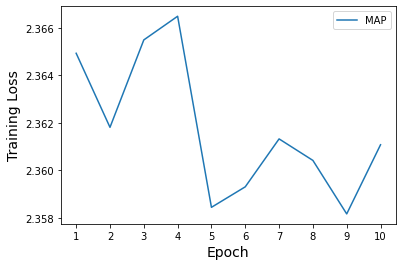

In [36]:
plot_losses("MAP", model.all_losses(), plt.subplot())